# Improved handling of potential evapotranspiration in hydrological studies with PyEt

This notebook is supporting the manuscript: Vremec et al. "Technical note: Improved handling of potential evapotranspiration in hydrological studies with *PyEt*". Submitted to: Hydrology and Earth System Sciences.

*M.Vremec (University of Graz), R. A. Collenteur (Eawag)*

Data source: 

* Example 1: KNMI - https://www.knmi.nl/home
* Example 2: E-OBS https://www.ecad.eu/
* Example 3: ZAMG - https://data.hub.zamg.ac.at

### The supporting Notebook is structured as follows:

* Benchmarking PET methods
* Example 1: Estimation of PET from station data
* Example 2: Estimate PET for gridded data
* Example 3: Calibration of PET models
* Example 4: The effect of $CO_2$ on future PET estimates

Table 1: Corresponding literature to each method.

| Method name       | Corresponding literature |
| ----------------- | ------------------------ |
| Penman            | Penman (1948) |
| Penman-Monteith   | Monteith (1965) |
| ASCE-PM           | Walter et al. (2000) |
| FAO-56            | Allen et al. (1998) |
| Priestley-Taylor  | Priestley and Taylor (1972), McMahon et al. (2013) |
| Kimberly-Penman   | Wright (1982) |
| Thom-Oliver       | Thom and Oliver (1977) |
| Blaney-Criddle    | Xu et al. (2001), McMahon et al. (2013), Schrödter (1985) |
| Hamon             | Hamon (1963), Ansorge et al. (2019), Oudin et al. (2005) |
| Romanenko         | Romanenko (1961), Xu et al. (2001) |
| Linacre           | Linacre (1977) |
| Haude             | Haude (1955), Schiff (1975) |
| Turc              | Turc (1961), Xu et al. (2001) |
| Jensen-Haise      | Jensen and Haise (1963), Jensen et al. (2016), Oudin et al. (2005) |
| McGuinness-Bordne | McGuinness and Bordne (1972) |
| Hargreaves        | Hargreaves and Samani (1982) |
| FAO-24            | Jensen et al. (1990) |
| Abtew             | Abtew (1996) |
| Makkink           | Makkink (1957), McMahon et al. (2013) |
| Oudin             | Oudin et al. (2005) |

## Import packages

In [1]:
# 1. Import needed Python packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import xarray as xr
import seaborn as sns

from scipy.optimize import least_squares
from scipy.stats import gaussian_kde
import pylab
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import pyet
from utils import *
pyet.show_versions()

Python version: 3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]
Numpy version: 1.21.5
Pandas version: 1.4.4
Pyet version: 1.2.3b


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
#edit default values for plots
params = {
    "font.family": "Arial",
    "legend.fontsize": "15",
    "axes.labelsize": "16",
    "xtick.labelsize": "15",
    "ytick.labelsize": "15",
    "xtick.direction": "in",
    "ytick.direction": "in",}
pylab.rcParams.update(params)

# 0. Benchmarking PET methods

In [4]:
# Read results from Guo et al., 2016
df_guo = pd.read_excel("data//example_0//df_Guo_2016.xlsx", index_col="daily", 
                         parse_dates=True).iloc[:50, :]

In [5]:
# Define input variables
lat = -0.6095
elevation = 48

rs = pyet.calc_rad_sol_in(df_guo["n"], lat, as1=0.23, bs1=0.5, nn=None)  # Compute solar radiation [MJ/m2day]
tmax = df_guo["Tmax"]  # Daily maximum temperature [°C]
tmin = df_guo["Tmin"] # Daily minimum temperature [°C]
tmean = (tmax+tmin)/2 # Daily mean temperature [°C]
rhmax = df_guo["RHmax"]  # Daily maximum relative humidity [%]
rhmin = df_guo["RHmin"]  # Daily minimum relative humidity [%]
rh = (rhmax+rhmin)/2    # Daily mean relative humidity [%]
uz = df_guo["uz"]  # Wind speed at 10 m [m/s]
z = 10  # Height of wind measurement [m]

wind_penman = uz * np.log(2/0.001) / np.log(z/0.001) # wind speed at 2 m after Penman 1948
wind_fao56 = uz * 4.87 / np.log(67.8*z-5.42)  # wind speed at 2 m after Allen et al., 1998

lambda1=pyet.calc_lambda(tmean=tmean)  # Latent Heat of Vaporization in PyEt [MJ kg-1] 
lambda0 = 2.45  # Latent Heat of Vaporization in Guo et al., 2016 [MJ kg-1] 
lambda_corr = lambda1 / lambda0  # Correction factor

In [6]:
# Benchmarking against R-Evapotranspiration package
df_pyet_guo = pyet.calculate_all(tmean, wind_fao56, rs, elevation, lat, tmax, tmin, rh, 
                                   rhmax=rhmax, rhmin=rhmin)

### Test Penman

In [7]:
#%%timeit
pyet_penman = pyet.penman(tmean, wind_penman, rs=rs, elevation=elevation, lat=lat, tmax=tmax, 
                          tmin=tmin, rh=rh, rhmax=rhmax, rhmin=rhmin, aw=2.626, bw=1.381, albedo=0.08) * lambda_corr

In [8]:
np.array_equal(pyet_penman.iloc[:10].round(1).values, df_guo["Penman"].iloc[:10].round(1).values)

True

### Test FAO-56, ASCE, Penman-Monteith

In [9]:
np.array_equal(df_pyet_guo["FAO-56"].iloc[:10].round(1).values, df_guo["PM"].iloc[:10].round(1).values)

True

In [10]:
pyet_pmasce = pyet.pm_asce(tmean, wind_fao56, rs=rs, elevation=elevation, lat=lat, tmax=tmax, 
                           tmin=tmin, rh=rh, rhmax=rhmax, rhmin=rhmin)

In [11]:
np.array_equal(pyet_pmasce.iloc[:10].round(1).values, df_guo["PM"].iloc[:10].round(1).values)

True

In [12]:
pyet_pm = pyet.pm(tmean, wind_fao56, rs=rs, elevation=elevation, lat=lat, tmax=tmax, tmin=tmin, rh=rh, 
                  rhmax=rhmax, rhmin=rhmin) * lambda_corr

In [13]:
np.array_equal(pyet_pm.iloc[:10].round(1).values, df_guo["PM"].iloc[:10].round(1).values)

True

### Test Makkink

In [14]:
pyet_makk = (pyet.makkink(tmean, rs=rs, elevation=elevation, k=0.61)  * lambda_corr - 0.12) 

In [15]:
np.array_equal(pyet_makk.iloc[:10].round(1).values, df_guo["Makkink"].iloc[:10].round(1).values)

True

### Test Priestley-Taylor

In [16]:
np.array_equal((df_pyet_guo["Priestley-Taylor"]*lambda_corr).iloc[:10].round(1).values, df_guo["PT"].iloc[:10].round(1).values)

True

### Hargreaves

In [17]:
pyet_hargreaves = pyet.hargreaves(tmean, tmax, tmin, lat, method=1)

In [18]:
np.array_equal(pyet_hargreaves.iloc[:10].round(1).values, df_guo["Har"].iloc[:10].round(1).values)

True

### Test Hamon

In [19]:
pyet_hamon = pyet.hamon(tmean, lat=lat, n=df_guo["n"], tmax=tmax, tmin=tmin, method=3)

In [20]:
np.array_equal(pyet_hamon.iloc[:10].round(1).values, df_guo["Hamon"].iloc[:10].round(1).values)

True

### Blaney Criddle

In [21]:
pyet_bc = pyet.blaney_criddle(tmean, lat, rhmin=rhmin, wind=wind_fao56, method=2, n=df_guo["n"], clip_zero=False)

In [22]:
np.array_equal(pyet_bc.iloc[:10].round(1).values, df_guo["BC"].iloc[:10].round(1).values)

True

### Romanenko

In [23]:
np.array_equal(df_pyet_guo["Romanenko"].iloc[:10].round(1).values, df_guo["Romanenko"].iloc[:10].round(1).values)

True

### McGuinness-Bordne

In [24]:
np.array_equal((df_pyet_guo["Mcguinness-Bordne"]*lambda_corr).iloc[:10].round(1).values, 
               df_guo["McG"].iloc[:10].round(1).values)

True

### Jensen-Haise

In [25]:
np.array_equal((df_pyet_guo["Jensen-Haise"]*lambda_corr).iloc[:10].round(1).values, 
               df_guo["JH"].iloc[:10].round(1).values)

True

### Linacre

In [26]:
pyet_linacre = pyet.linacre(tmean, elevation, lat, tdew=df_guo["Tdew"])

In [27]:
np.array_equal(pyet_linacre.iloc[:10].round(1).values, 
               df_guo["Linacre"].iloc[:10].round(1).values)

True

### Abtew

In [28]:
pyet_abtew = pyet.abtew(tmean, rs, k=0.52) * lambda_corr

In [29]:
np.array_equal(pyet_abtew.iloc[:10].round(1).values, 
               df_guo["Abtew"].iloc[:10].round(1).values)

True

### Turc

In [30]:
np.array_equal(df_pyet_guo["Turc"].iloc[:10].round(1).values, 
               df_guo["Turc"].iloc[:10].round(1).values)

True

### Benchmarking against McMahon et al. 2016

In [31]:
# Benchmarking against McMahon et al. 2016
# Makkink # Based on example S19.91, p 80 McMahon_etal_2013
tmean = pd.Series([11.5], index=pd.DatetimeIndex(["1980-07-20"]))
rs = pd.Series([17.194], index=pd.DatetimeIndex(["1980-07-20"]))
elevation = 546
mcm_mak = [2.3928, (pyet.makkink(tmean, rs, elevation=elevation, k=0.61)) -0.12] # correction for different formula in McMahon_2013
# Blaney Criddle # Based on example S19.93, McMahon_etal_2013
tmean = pd.Series([11.5], index=pd.DatetimeIndex(["1980-07-20"]))
rhmin = pd.Series([25], index=pd.DatetimeIndex(["1980-07-20"]))
wind = pd.Series([0.5903], index=pd.DatetimeIndex(["1980-07-20"]))
n = pd.Series([10.7], index=pd.DatetimeIndex(["1980-07-20"]))
py = pd.Series([0.2436], index=pd.DatetimeIndex(["1980-07-20"]))
lat = -23.7951 * np.pi / 180
mcm_bc = [3.1426, pyet.blaney_criddle(tmean, lat, wind=wind, n=n, rhmin=rhmin, py=py, method=2)]
# Based on example S19.99, McMahon_etal_2013 # Based on example S19.99, McMahon_etal_2013
tmean = pd.Series([11.5], index=pd.DatetimeIndex(["1980-07-20"]))
rhmean = pd.Series([48], index=pd.DatetimeIndex(["1980-07-20"]))
rs = pd.Series([17.194], index=pd.DatetimeIndex(["1980-07-20"]))
mcm_turc = [pyet.turc(tmean, rs, rhmean, k=0.32), 2.6727]
# Based on example S19.101, McMahon_etal_2013
tmean = pd.Series([11.5], index=pd.DatetimeIndex(["1980-07-20"]))
tmax = pd.Series([21], index=pd.DatetimeIndex(["1980-07-20"]))
tmin = pd.Series([2], index=pd.DatetimeIndex(["1980-07-20"]))
lat = -23.7951 * np.pi / 180
mcm_har = [4.1129, pyet.hargreaves(tmean, tmax, tmin, lat, method=1)]

# Based on example S19.109, McMahon_etal_2013
tmean = pd.Series([11.5], index=pd.DatetimeIndex(["1980-07-20"]))
rn = pd.Series([8.6401], index=pd.DatetimeIndex(["1980-07-20"]))
elevation = 546
mcm_pt = [2.6083, pyet.priestley_taylor(tmean, rn=rn, elevation=elevation, alpha=1.26)]

In [32]:
# Based on example 5.1, P89 Schrodter 1985
tmean = pd.Series([17.3], index=pd.DatetimeIndex(["1980-07-20"]))
lat = 50 * np.pi / 180
sch_bc = [3.9, pyet.blaney_criddle(tmean, lat, method=0)]
# Based on example 5.2, P95 Schrodter 1985
tmean = pd.Series([21.5], index=pd.DatetimeIndex(["1980-07-20"]))
ea = pd.Series([1.19], index=pd.DatetimeIndex(["1980-07-20"]))
e0 = pyet.calc_e0(tmean)
rh = ea / e0 * 100
sch_haude = [3.6, pyet.haude(tmean, rh=rh, k=0.26 / 0.35)]

In [33]:
# Benchmarking against FAO-56
# Hargreasves # Based on example S19.46,p 78 TestFAO56
tmax = pd.Series([26.6], index=pd.DatetimeIndex(["2015-07-15"]))
tmin = pd.Series([14.8], index=pd.DatetimeIndex(["2015-07-15"]))
tmean = (tmax + tmin) / 2
lat = 45.72 * np.pi / 180
fao_har = [5.0, pyet.hargreaves(tmean, tmax, tmin, lat)]

# Based on Example 18, p. 72 FAO.
wind = pd.Series([2.078], index=pd.DatetimeIndex(["2015-07-06"]))
tmax = pd.Series([21.5], index=pd.DatetimeIndex(["2015-07-06"]))
tmin = pd.Series([12.3], index=pd.DatetimeIndex(["2015-07-06"]))
tmean = (tmax + tmin) / 2
rhmax = pd.Series([84], index=pd.DatetimeIndex(["2015-07-06"]))
rhmin = pd.Series([63], index=pd.DatetimeIndex(["2015-07-06"]))
rs = pd.Series([22.07], index=pd.DatetimeIndex(["2015-07-06"]))
n = 9.25
nn = 16.1
elevation = 100
lat = 50.80 * np.pi / 180
fao_56 = [3.9, pyet.pm_fao56(tmean, wind, elevation=elevation, lat=lat, rs=rs, tmax=tmax, tmin=tmin, rhmax=rhmax,
                            rhmin=rhmin, n=n, nn=nn)]

In [34]:
def add_metrics(ax, x, y):
    ax.text(0.55, 0.04, "$Bias$ = " + str(
        round(bias(np.asarray(y), np.asarray(x)), 2)) +
            "\n" + "$R^2$ = " + str(
        round(rsquared(np.asarray(y), np.asarray(x)),
              2)) +
            "\n" + "KGE = " + str(
        round(kge(np.asarray(y), np.asarray(x)), 2)), fontsize=12,
            color="k", zorder=10, transform=ax.transAxes)
    return ax

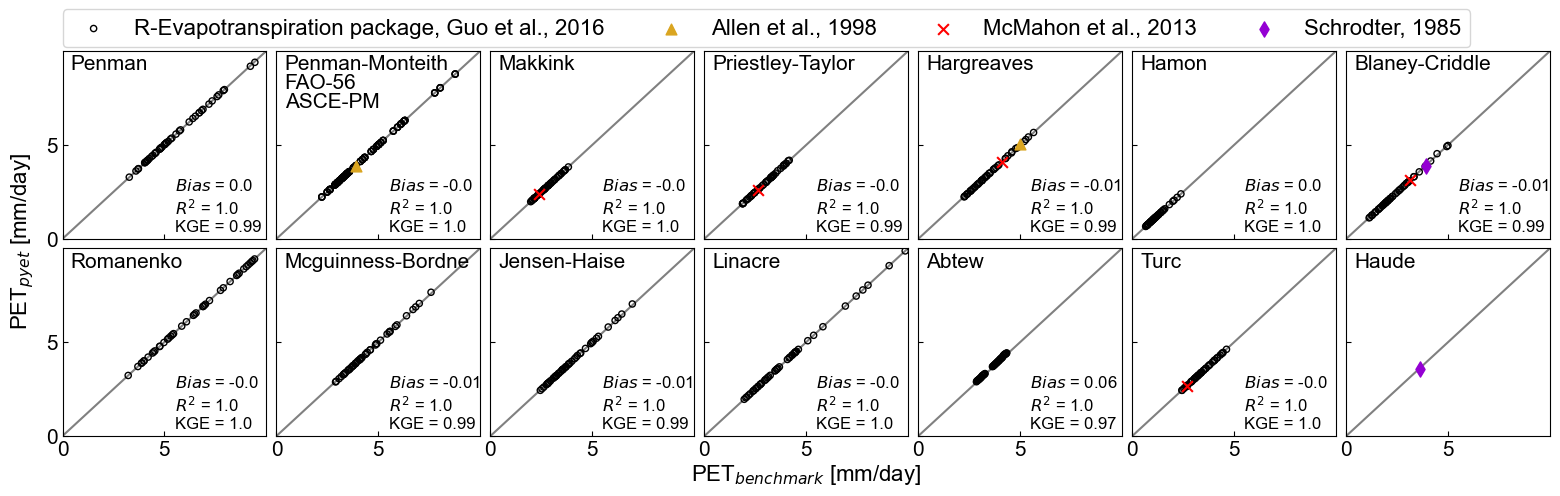

In [35]:
figw_1c = 8.5  # maximum width for 1 column
figw_2c = 17.5  # maximum width for 2 columns
cm1 = 1 / 2.54  # centimeters in inches
fs = 15
ms1 = 20
ms2 = 60

fig,axs=plt.subplots(ncols=7, nrows=2, figsize=(figw_2c,5))
axs[0,0].scatter(df_guo["Penman"], pyet_penman, c="None", marker="o", s=20, edgecolors="k")
axs[0,0].text(0.04, 0.9, "Penman", transform=axs[0, 0].transAxes, fontsize=fs)
add_metrics(axs[0,0], df_guo["Penman"], pyet_penman)

axs[0,1].scatter(df_guo["PM"], df_pyet_guo["FAO-56"], c="None", marker="o", s=20, edgecolors="k")
axs[0,1].text(0.04, 0.8, "FAO-56", transform=axs[0, 1].transAxes, fontsize=fs)
axs[0,1].scatter(fao_56[0], fao_56[1], c="goldenrod", marker="^", s=ms2, zorder=10)

axs[0,1].scatter(df_guo["PM"], pyet_pmasce, c="None", marker="o", s=20, edgecolors="k")
axs[0,1].text(0.04, 0.7, "ASCE-PM", transform=axs[0, 1].transAxes, fontsize=fs)
add_metrics(axs[0,1], np.append(df_guo["PM"].values, fao_56[0]), 
            np.append(df_pyet_guo["FAO-56"].values, fao_56[1]))

axs[0,1].scatter(df_guo["PM"], pyet_pm, c="None", marker="o", s=20, edgecolors="k")
axs[0,1].text(0.04, 0.9, "Penman-Monteith", transform=axs[0, 1].transAxes, fontsize=fs)

axs[0,2].scatter(df_guo["Makkink"], pyet_makk, c="None", marker="o", s=20, edgecolors="k")
axs[0,2].text(0.04, 0.9, "Makkink", transform=axs[0, 2].transAxes, fontsize=fs)
axs[0,2].scatter(mcm_mak[0], mcm_mak[1], c="red", marker="x", s=ms2, zorder=10)
add_metrics(axs[0,2], np.append(df_guo["Makkink"].values, mcm_mak[0]), 
            np.append(pyet_makk.values, mcm_mak[1]))


axs[0,3].scatter(df_guo["PT"], df_pyet_guo["Priestley-Taylor"], c="None", marker="o", s=20, edgecolors="k")
axs[0,3].text(0.04, 0.9, "Priestley-Taylor", transform=axs[0, 3].transAxes, fontsize=fs)
axs[0,3].scatter(mcm_pt[0], mcm_pt[1], c="red", marker="x", s=ms2, zorder=10)
add_metrics(axs[0,3], np.append(df_guo["PT"].values, mcm_pt[0]), 
            np.append(df_pyet_guo["Priestley-Taylor"].values, mcm_pt[1]))

p1=axs[0,4].scatter(df_guo["Har"], pyet_hargreaves, c="None", marker="o", s=20, edgecolors="k")
axs[0,4].text(0.04, 0.9, "Hargreaves", transform=axs[0, 4].transAxes, fontsize=fs)
p2=axs[0,4].scatter(fao_har[0], fao_har[1], c="goldenrod", marker="^", s=ms2, zorder=10)
p3=axs[0,4].scatter(mcm_har[0], mcm_har[1], c="red", marker="x", s=ms2, zorder=10)
add_metrics(axs[0,4], np.append(df_guo["Har"].values, mcm_har[0]), 
            np.append(pyet_hargreaves.values, mcm_har[1]))

axs[0,5].scatter(df_guo["Hamon"], pyet_hamon, c="None", marker="o", s=20, edgecolors="k")
axs[0,5].text(0.04, 0.9, "Hamon", transform=axs[0, 5].transAxes, fontsize=fs)
add_metrics(axs[0,5], df_guo["Hamon"], pyet_hamon)

axs[0, 6].scatter(df_guo["BC"], pyet_bc, c="None", marker="o", s=20, edgecolors="k")
axs[0,6].text(0.04, 0.9, "Blaney-Criddle", transform=axs[0, 6].transAxes, fontsize=fs)
axs[0,6].scatter(mcm_bc[0], mcm_bc[1], c="red", marker="x", s=ms2, zorder=10)
p4=axs[0,6].scatter(sch_bc[0], sch_bc[1], c="darkviolet", marker="d", s=ms2, zorder=10)
add_metrics(axs[0,6], np.append(df_guo["BC"].values, sch_bc[0]), 
            np.append(pyet_bc.values, sch_bc[1]))

axs[1,0].scatter(df_guo["Romanenko"], df_pyet_guo["Romanenko"], c="None", marker="o", s=20, edgecolors="k")
axs[1,0].text(0.04, 0.9, "Romanenko", transform=axs[1, 0].transAxes, fontsize=fs)
add_metrics(axs[1,0], df_guo["Romanenko"], df_pyet_guo["Romanenko"])

axs[1,1].scatter(df_guo["McG"], df_pyet_guo["Mcguinness-Bordne"], c="None", marker="o", s=20, edgecolors="k")
axs[1,1].text(0.04, 0.9, "Mcguinness-Bordne", transform=axs[1, 1].transAxes, fontsize=fs)
add_metrics(axs[1,1], df_guo["McG"], df_pyet_guo["Mcguinness-Bordne"])

axs[1,2].scatter(df_guo["JH"], df_pyet_guo["Jensen-Haise"], c="None", marker="o", s=20, edgecolors="k")
axs[1,2].text(0.04, 0.9, "Jensen-Haise", transform=axs[1, 2].transAxes, fontsize=fs)
add_metrics(axs[1,2], df_guo["JH"], df_pyet_guo["Jensen-Haise"])

axs[1,3].scatter(df_guo["Linacre"], pyet_linacre, c="None", marker="o", s=20, edgecolors="k")
axs[1,3].text(0.04, 0.9, "Linacre", transform=axs[1, 3].transAxes, fontsize=fs)
add_metrics(axs[1,3], df_guo["Linacre"], pyet_linacre)

axs[1,4].scatter(df_guo["Abtew"], df_pyet_guo["Abtew"], c="None", marker="o", s=20, edgecolors="k")
axs[1,4].text(0.04, 0.9, "Abtew", transform=axs[1, 4].transAxes, fontsize=fs)
add_metrics(axs[1,4], df_guo["Abtew"], df_pyet_guo["Abtew"])

axs[1,5].scatter(df_guo["Turc"], df_pyet_guo["Turc"], c="None", marker="o", s=20, edgecolors="k")
axs[1,5].text(0.04, 0.9, "Turc", transform=axs[1, 5].transAxes, fontsize=fs)
axs[1,5].scatter(mcm_turc[0], mcm_turc[1], c="red", marker="x", s=ms2, zorder=10)
add_metrics(axs[1,5], np.append(df_guo["Turc"].values, mcm_turc[0]), 
            np.append(df_pyet_guo["Turc"].values, mcm_turc[1]))

axs[1,6].text(0.04, 0.9, "Haude", transform=axs[1, 6].transAxes, fontsize=fs)
axs[1,6].scatter(sch_haude[0], sch_haude[1], c="darkviolet", marker="d", s=ms2, zorder=10)

for i in (0,1,2,3,4,5,6):
    axs[0,i].set_xticklabels([]) 
    for j in (0, 1):
        axs[j,i].set_xlim(0,10)
        axs[j,i].set_ylim(0,10)
        axs[j,i].plot([0, 10], [0, 10], color="gray", zorder=-10)
        axs[j,i].set_xticks([0, 5])
        axs[j,i].set_yticks([0, 5])
        axs[j,i].set_yticklabels([])
        axs[j,0].set_yticklabels([0, 5])

axs[0,i].set_yticklabels([]) 

axs[0,0].legend((p1,p2,p3,p4), ("R-Evapotranspiration package, Guo et al., 2016", 
                                "Allen et al., 1998", "McMahon et al., 2013", "Schrodter, 1985"), ncol=4, loc=[0,1.02], fontsize=16)
fig.supxlabel("PET$_{benchmark}$ [mm/day]", x=0.475, fontsize=16)
fig.supylabel("PET$_{pyet}$ [mm/day]", fontsize=16)
fig.subplots_adjust(wspace=0.05, hspace=0.05, left=0.05)
plt.tight_layout()
#fig.savefig("figure1.png", dpi=600, bbox_inches="tight")

# Example 1: Estimation of PET from station data

In this example potential evapotranspiration is estimated for the town of De Bilt in The Netherlands using data provided by the Royal Netherlands Meteorological Institute (KNMI). The reference method used by the KNMI for the estimation of potential evapotranspiration is the Makkink method, also implemented in *PyEt*. The $PET$ computed with the Makkink method is compared to the $PET$ values from all other methods in *PyEt*. A number of steps are taken in a Python script to estimate $PET$. The code implementing these steps is shown in the code example bellow. *PyEt* provides a convenience method to compute the $PET$ with all available methods, *pyet.calculate_all()*.

Data source: KNMI - https://dataplatform.knmi.nl/

In [54]:
# Load the meteorological data.
meteo = pd.read_csv("data//example_0//0_example_meteo.csv", index_col=0, parse_dates=True)

In [61]:
# Determine the necessary input data for the $PET$ model.
tmean, tmax, tmin, rh, rs, wind, pet_knmi = (meteo[col] for col in meteo.columns)
lat = 0.91  # define latitude [radians]
elevation = 4  # define elevation [meters above sea-level]

In [62]:
# Estimate the potential evapotranspiration with all methods or the method of choice.
pet_df  = pyet.calculate_all(tmean, wind, rs, elevation, lat, tmax, tmin, rh)

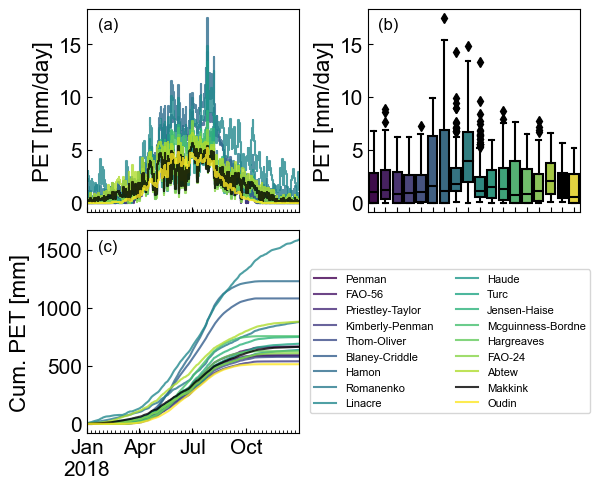

In [63]:
# Visualize and analyze the results.
viridis = cm.get_cmap('viridis', len(pet_df.columns))
colors = [viridis(i) for i in range(0, len(pet_df.columns))]
colors[-2] = "k"

fig, axs = plt.subplots(2, 2, figsize=(6,5), layout="constrained")
axs = axs.flatten()
axs[3].axis("off")

pet_df.plot(color=colors, legend=False, ax=axs[0], alpha=0.8, drawstyle="steps-mid")
axs[0].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
axs[0].set_ylabel("PET [mm/day]")
axs[0].set_xlabel("")
axs[0].set_xticklabels([])

handles = pet_df.cumsum().plot(color=colors, legend=False, ax=axs[2], alpha=0.8)
axs[2].set_ylabel("Cum. PET [mm]")
axs[2].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
axs[2].set_xlabel("")

sns.boxplot(data=pet_df, ax=axs[1], palette=colors)
axs[1].set_ylabel("PET [mm/day]")
axs[1].set_xlabel("")

axs[1].set_xticklabels([])

for i, letter in enumerate(["a", "b", "c"]):
    axs[i].text(0.05, 0.9, "({})".format(letter), transform=axs[i].transAxes, fontsize=12)

plt.tight_layout()

axs[2].legend(loc=(1.05,0.1), ncol=2, bbox_transform=axs[0].transAxes, fontsize=8)
#fig.savefig("figure2.png", dpi=600, bbox_inches="tight")

# Example 2: Estimate PET for gridded data

Data source: E-OBS https://www.ecad.eu/

In [47]:
# Load E-OBS data
wind = xr.open_dataset("data//example_0//fg_ens_mean_0.25deg_reg_2018_v25.0e.nc", 
                       engine="netcdf4")["fg"]
tmax = xr.open_dataset("data//example_0//tx_ens_mean_0.25deg_reg_2018_v25.0e.nc", 
                       engine="netcdf4").sel(longitude=slice(wind.longitude.min(), wind.longitude.max()), 
                                             latitude=slice(wind.latitude.min(), wind.latitude.max()))["tx"]
tmin = xr.open_dataset("data//example_0//tn_ens_mean_0.25deg_reg_2018_v25.0e.nc", 
                       engine="netcdf4").sel(longitude=slice(wind.longitude.min(), wind.longitude.max()), 
                                             latitude=slice(wind.latitude.min(), wind.latitude.max()))["tn"]
tmean = xr.open_dataset("data//example_0//tg_ens_mean_0.25deg_reg_2018_v25.0e.nc", 
                        engine="netcdf4").sel(longitude=slice(wind.longitude.min(), wind.longitude.max()), 
                                              latitude=slice(wind.latitude.min(), wind.latitude.max()))["tg"]
rs = xr.open_dataset("data//example_0//qq_ens_mean_0.25deg_reg_2018_v25.0e.nc", 
                     engine="netcdf4").sel(lon=slice(wind.longitude.min(), wind.longitude.max()), 
                                           lat=slice(wind.latitude.min(), wind.latitude.max()))
rs = rs.rename_dims({"lon":"longitude", 
                     "lat":"latitude"}).rename({"lon":"longitude", 
                                                "lat":"latitude"}).sel(ensemble=10)["qq"] * 86400 / 1000000  # concert to [MJ/m2day]
rh = xr.open_dataset("data//example_0//hu_ens_mean_0.25deg_reg_2018_v25.0e.nc", 
                     engine="netcdf4").sel(lon=slice(wind.longitude.min(), wind.longitude.max()), 
                                           lat=slice(wind.latitude.min(), wind.latitude.max()))
rh = rh.rename_dims({"lon":"longitude", "lat":"latitude"}).rename({"lon":"longitude", "lat":"latitude"})["hu"]
elevation =  xr.open_dataset("data//example_0//elev_ens_0.25deg_reg_v25.0e.nc", 
                     engine="netcdf4").sel(longitude=slice(wind.longitude.min(), wind.longitude.max()), 
                                           latitude=slice(wind.latitude.min(), wind.latitude.max()))["elevation"].fillna(0)
lat = tmean.latitude * np.pi / 180
lat = lat.expand_dims(dim={"longitude":tmean.longitude}, axis=1)

In [48]:
# Estimate potential Evapotranspiration
pm_fao56 = pyet.pm_fao56(tmean, wind, rs=rs, elevation=elevation, lat=lat, tmax=tmax, tmin=tmin, rh=rh)
makkink = pyet.makkink(tmean, rs, elevation=elevation)
hargreaves = pyet.hargreaves(tmean, tmax, tmin, lat=lat)

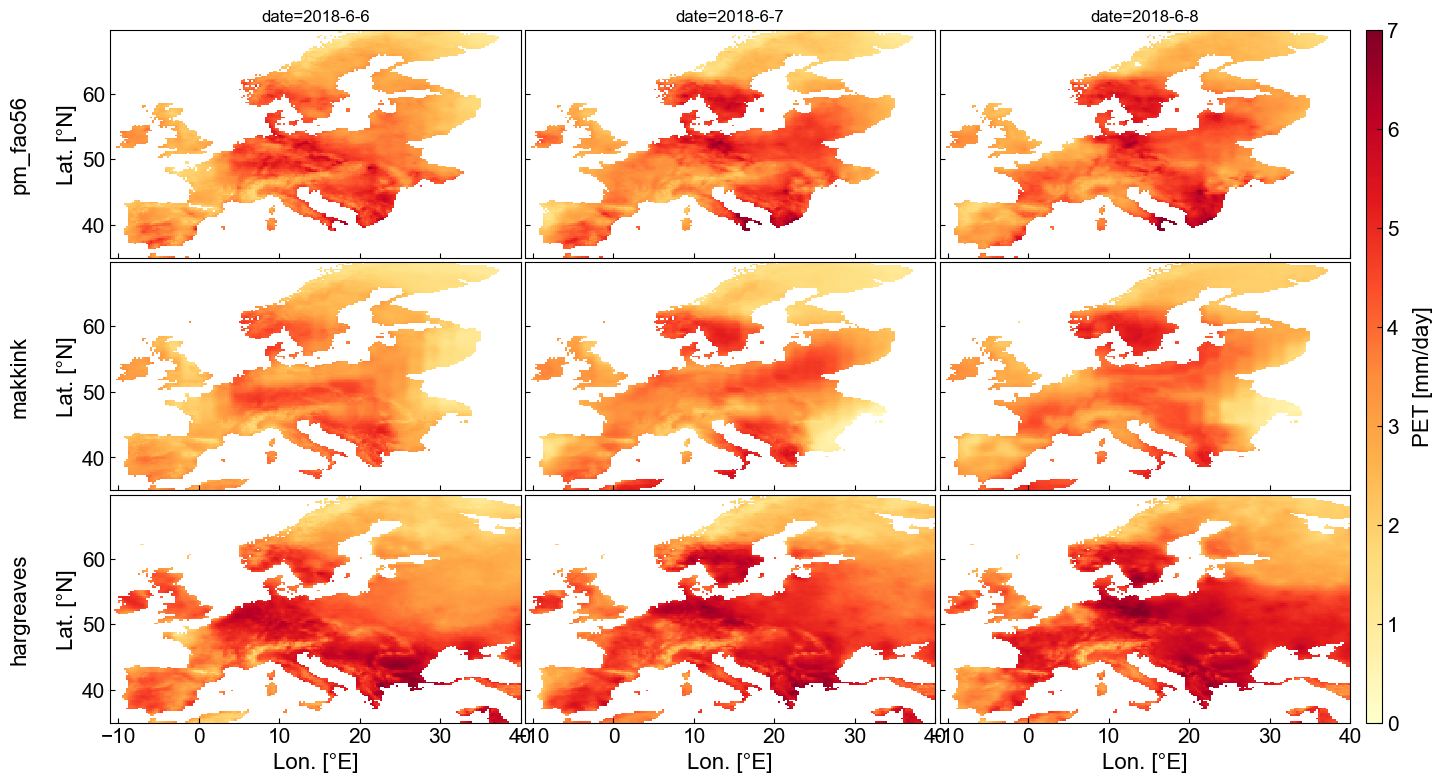

In [49]:
vmax, vmin = 7, 0
cmap = "YlOrRd"

try:
    import cartopy.crs as ccrs   
    import cartopy.feature as cf
    fs = 15  # fontsize
    fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(16, 9), sharey=True, sharex=True, subplot_kw={'projection': ccrs.PlateCarree()})
    for date, i in zip(["2018-6-6", "2018-6-7", "2018-6-8"],[0,1,2]):
        pm_fao56.sel(time=date).plot(ax=axs[0,i],vmax=vmax, vmin=vmin, add_colorbar=False, cmap=cmap)
        makkink.sel(time=date).plot(ax=axs[1,i],vmax=vmax, vmin=vmin, add_colorbar=False, cmap=cmap)
        im = hargreaves.sel(time=date).plot(ax=axs[2,i],vmax=vmax, vmin=vmin, add_colorbar=False, cmap=cmap) 
        lon_min, lon_max, lat_min, lat_max = (-14, 42, 35, 67)
        for j in (0,1,2):
            axs[j, i].add_feature(cf.BORDERS.with_scale("50m"), lw=0.3)
            axs[j, i].add_feature(cf.COASTLINE.with_scale("50m"), lw=0.4)
            axs[j, i].set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    for date, i in zip(["2018-6-6", "2018-6-7", "2018-6-8"],[0,1,2]):
        for j in (0,1,2):      
            axs[j,i].set_title("") 
            gl = axs[i,j].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, linewidth=0.25)
            gl.right_labels = False
            gl.top_labels = False
            gl.xlabel_style = {'size': 12}
            gl.ylabel_style = {'size': 12}
            if i == 0 or i == 1:
                gl.bottom_labels = False
            if j == 1 or j == 2:
                gl.left_labels = False 
        axs[0,i].set_title("date="+date, fontsize=fs)        
    
    cbar_ax = fig.add_axes([0.91, 0.11, 0.01, 0.77])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.set_label("PET [mm/day]", labelpad=10)
    axs[0,0].text(-0.13, 0.55, 'pm_fao56', va='bottom', ha='center', fontsize=fs,
            rotation='vertical', rotation_mode='anchor', transform=axs[0,0].transAxes)
    axs[1,0].text(-0.13, 0.55, 'makkink', va='bottom', ha='center', fontsize=fs,
                 rotation='vertical', rotation_mode='anchor', transform=axs[1,0].transAxes)
    axs[2,0].text(-0.13, 0.55, 'hargreaves', va='bottom', ha='center', fontsize=fs,
            rotation='vertical', rotation_mode='anchor', transform=axs[2,0].transAxes)
        
except ImportError:
    fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(16, 9), sharey=True, sharex=True)    
    for date, i in zip(["2018-6-6", "2018-6-7", "2018-6-8"],[0,1,2]):
        im1 = pm_fao56.sel(time=date).plot(ax=axs[0,i],vmax=vmax, vmin=vmin, add_colorbar=False, cmap=cmap)
        im2 = makkink.sel(time=date).plot(ax=axs[1,i],vmax=vmax, vmin=vmin, add_colorbar=False, cmap=cmap)
        im3 = hargreaves.sel(time=date).plot(ax=axs[2,i],vmax=vmax, vmin=vmin, add_colorbar=False, cmap=cmap)

    for method, date, i in zip(["pm_fao56", "makkink", "hargreaves"], ["2018-6-6", "2018-6-7", "2018-6-8"],[0,1,2]):
        for j in (0,1,2):        
            axs[i, j].set_ylabel("")
            axs[i, j].set_xlabel("")
            axs[i, j].set_title("")
            axs[2,j].set_xlabel("Lon. [°E]")
        axs[i, 0].set_ylabel(method + "\n\nLat. [°N]")
        axs[0,i].set_title("date="+date)
    axs[0,0].set_xlabel("alalal")
    cbar_ax = fig.add_axes([0.91, 0.11, 0.01, 0.77])
    cbar = fig.colorbar(im3, cax=cbar_ax)
    cbar.set_label("PET [mm/day]", labelpad=10)
    plt.subplots_adjust(hspace=0.02, wspace=0.1)

plt.subplots_adjust(hspace=0.02, wspace=0.01)

#fig.savefig("figure3.png", dpi=300, bbox_inches="tight")

# Example 3: Calibration of PET models

Data source: ZAMG - https://data.hub.zamg.ac.at

In [50]:
#Load station data
data_16412 = pd.read_csv('data//example_1//klima_daily.csv', index_col=1, parse_dates=True)
data_16412.head()

,station,strahl,rel,t,tmax,tmin,vv
time,,,,,,,
2000-01-01,16412,300.0,80.0,-2.7,0.5,-5.8,1.0
2000-01-02,16412,250.0,86.0,0.2,2.5,-2.1,1.0
2000-01-03,16412,598.0,86.0,0.6,3.6,-2.4,1.0
2000-01-04,16412,619.0,83.0,-0.5,4.5,-5.5,1.0
2000-01-05,16412,463.0,84.0,-0.1,5.4,-5.5,1.0


In [51]:
# Convert Glabalstrahlung J/cm2 to MJ/m2 by dividing to 100
meteo = pd.DataFrame({"time":data_16412.index, "tmean":data_16412.t, "tmax":data_16412.tmax, 
                      "tmin":data_16412.tmin, "rh":data_16412.rel, 
                      "wind":data_16412.vv, "rs":data_16412.strahl/100})

time, tmean, tmax, tmin, rh, wind, rs = [meteo[col] for col in meteo.columns]

lat = 47.077778 * np.pi / 180  # Latitude of the meteorological station, converting from degrees to radians
elevation = 367  # meters above sea-level

# Estimate evaporation with all different methods and create a dataframe
pet_df = pyet.calculate_all(tmean, wind, rs, elevation, lat, tmax=tmax,
                            tmin=tmin, rh=rh)

## 3.1 Calibrate alternative temperature models to Penman-Monteith

In [21]:
# Calibrate alternative temperature models to Penman-Monteith
methods = ["oudin", "hargreaves", "mcguinness_bordne", "hamon", "blaney_criddle"]

# Define initial values for calibration for each method
params = [[100, 5], [0.0135], [0.0147], [1], [-1.55, 0.96]]

# Define input for each method
input2 = ([tmean, lat], [tmean, tmax, tmin, lat], [tmean, lat],
          [tmean, lat], [tmean, lat])

# Define function to simulate the models and use required input
def simulate(params, method, input1):   
    input1_1 = input1.copy()
    method = getattr(pyet, method)
    for par in params:
        input1_1.append(par)
    return method(*input1_1)

# Define function to estimate residuals    
def residuals(params, info):
    method, input1, obs = info
    sim = simulate(params, method, input1)
    return sim - obs

In [22]:
# Calibrate the models to Penman-Monteith
obs = pet_df["FAO-56"]
sollutions2 = []
for i in np.arange(0,len(methods)):
    res_1 = least_squares(residuals, params[i], args=[[methods[i], input2[i], obs]])
    sollutions2.append(res_1.x)

In [23]:
# Create DataFrame with PET estimated with default (params) and calibrated parameters(sollutions2)
pet_df_def = pd.DataFrame()
pet_df_cali = pd.DataFrame()
for i in np.arange(0, len(methods)):
    pet_df_def[methods[i]] = simulate(params[i], methods[i], input2[i])
    pet_df_cali[methods[i]] = simulate(sollutions2[i], methods[i], input2[i])

## 3.2 Hindcasting PET for Graz, Austria

In [24]:
# Load Spartacus dataset
spartacus = xr.open_dataset("data//example_0//spartacus-daily_19610101T0000_20211231T0000.nc", 
                            engine="netcdf4")
spartacus_cali = spartacus.copy()

In [25]:
# Define new input
tmean_spartacus = (spartacus["Tx"] + spartacus["Tn"]) / 2
tmax_spartacus = spartacus["Tx"]
tmin_spartacus = spartacus["Tn"]
lat_spartacus = spartacus.lat * np.pi / 180  # from degrees to radians
input_spartacus = ([tmean_spartacus, lat_spartacus], 
                   [tmean_spartacus, tmax_spartacus, tmin_spartacus, lat_spartacus], 
                   [tmean_spartacus, lat_spartacus],
                   [tmean_spartacus, lat_spartacus], [tmean_spartacus, lat_spartacus])

In [26]:
# Estimate PET and add it to the xarray.Dataset
for i in np.arange(0,len(methods)):
    spartacus[methods[i]] = simulate(params[i], methods[i], input_spartacus[i])
    spartacus_cali[methods[i]] = simulate(sollutions2[i], methods[i], input_spartacus[i])

In [27]:
# Create DataFrame with PET estimated with default (params) and calibrated (sollutions2) models
df_def = spartacus.to_dataframe().reset_index(level=[1,1]).drop(columns=["y", "Tn", "Tx", "lambert_conformal_conic", "lon", "lat"])
df_cali = spartacus_cali.to_dataframe().reset_index(level=[1,1]).drop(columns=["y", "Tn", "Tx", "lambert_conformal_conic", "lon", "lat"])

In [28]:
def scatter_1(ax, x, y, label="treatment", xlabel="obs", ylabel="sim",
              best_fit=True, veg_ws=None):
    compare = pd.DataFrame({"x": x, "y": y})
    if veg_ws is not None:
        compare[veg_ws == 0] = np.nan
    compare = compare.dropna()
    xy = np.vstack([compare["x"].values,compare["y"].values])
    z = gaussian_kde(xy)(xy)
    density = ax.scatter(compare["x"], compare["y"], marker="o", s=2, c=z)#, fillstyle="none")
    ax.plot([-0.1, 10], [-0.1, 10], color="dodgerblue", alpha=0.7,
            linewidth="0.8")
    ax.axes.set_xticks(np.arange(0, 10 + 2, 2))
    ax.axes.set_yticks(np.arange(0, 10 + 2, 2))
    ax.set_xlim(-0.1, 10)
    ax.set_ylim(-0.1, 10)
    if best_fit:
        p = np.polyfit(compare["x"], compare["y"], 1)
        f = np.poly1d(p)

        # Calculating new x's and y's
        x_new = np.linspace(0, 10, y.size)
        y_new = f(x_new)

        # Plotting the best fit line with the equation as a legend in latex
        ax.plot(x_new, y_new, "r--", linewidth="0.8")
    ax.text(0.02, 0.9, f"{label}", color="k", zorder=10,
            transform=ax.transAxes)
    ax.text(0.6, 0.04, "$Bias$ = " + str(
        round(bias(np.asarray(compare["y"]), np.asarray(compare["x"])), 2)) +
            "\n" + "$R^2$ = " + str(
        round(rsquared(np.asarray(compare["y"]), np.asarray(compare["x"])),
              2)) +
            "\n" + "KGE = " + str(
        round(kge(np.asarray(compare["y"]), np.asarray(compare["x"])), 2)),
            color="k", zorder=10, transform=ax.transAxes)
    return density

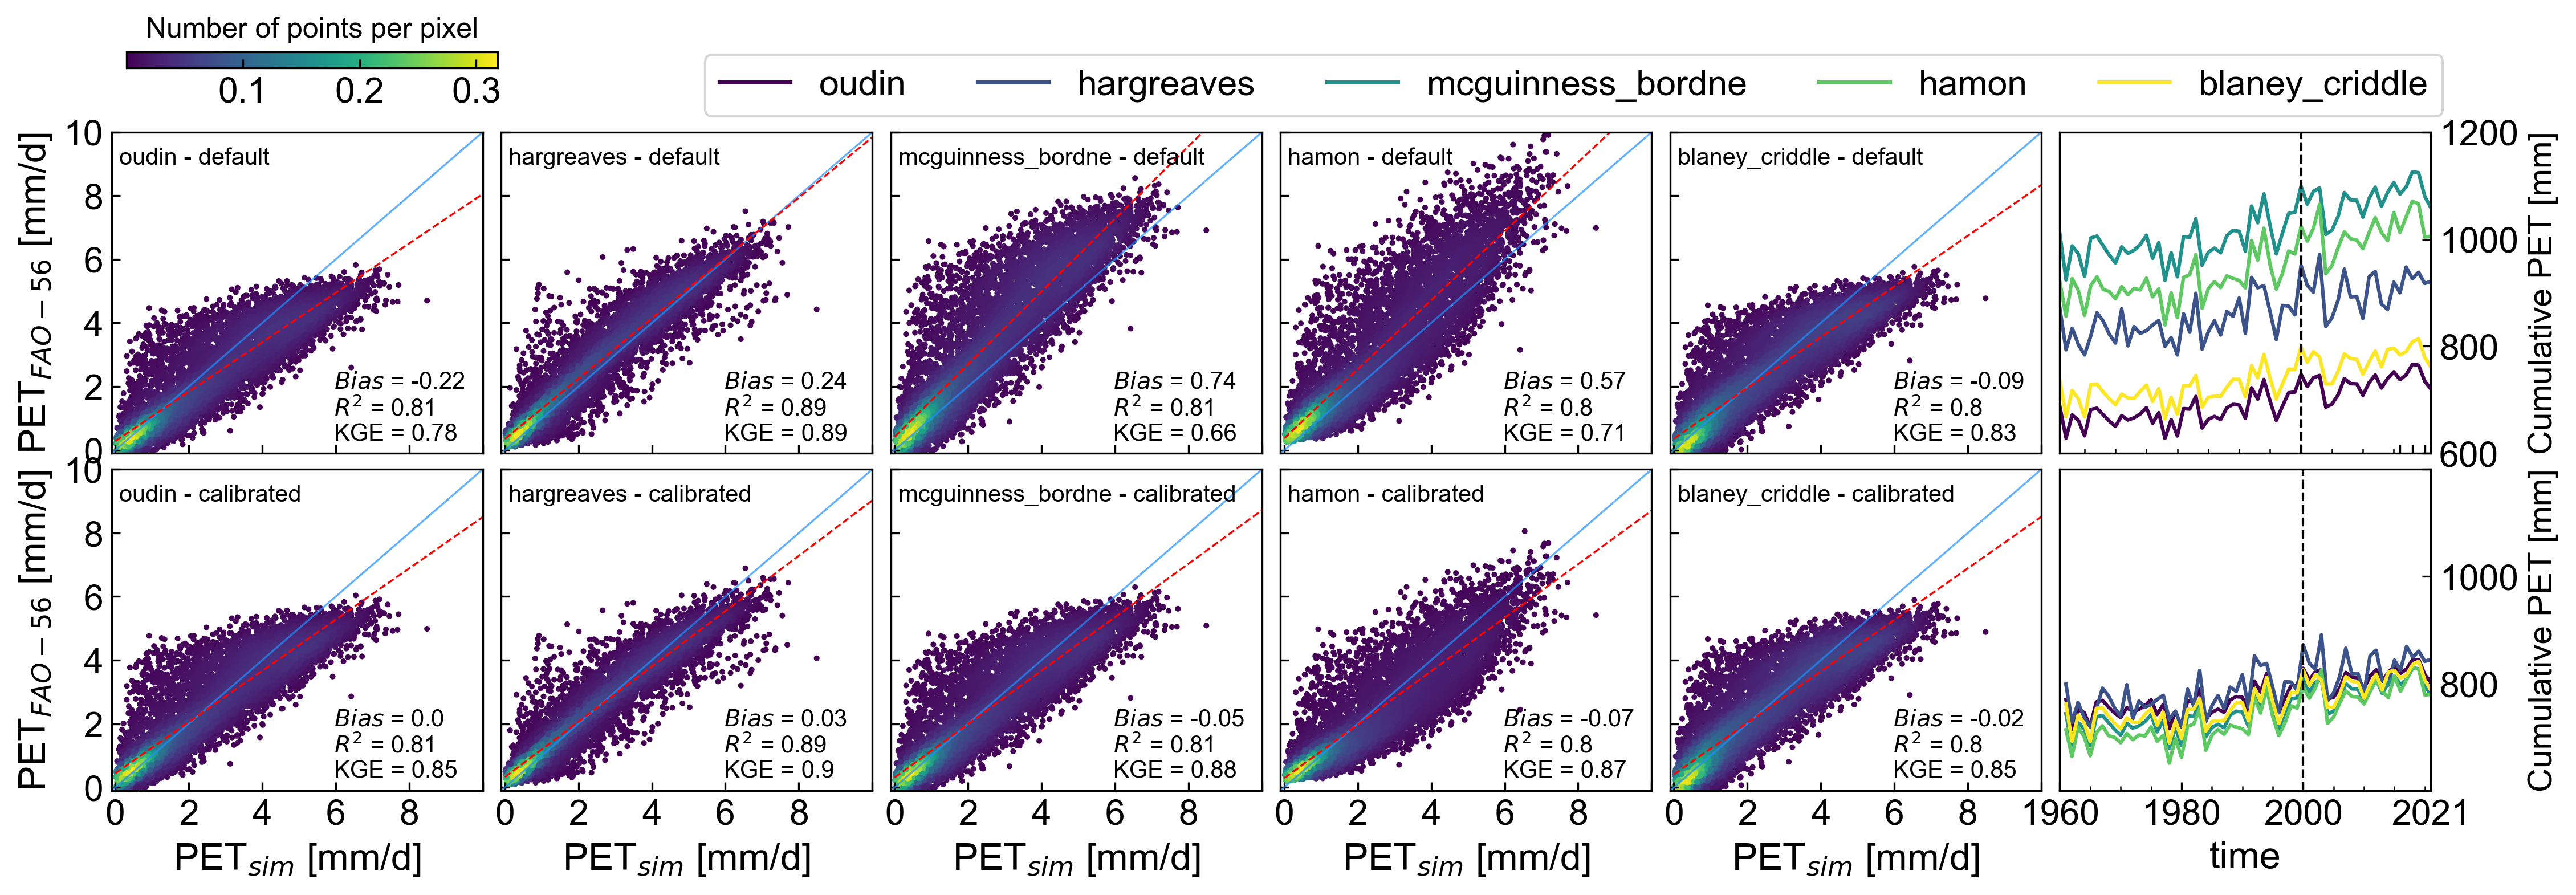

In [30]:
figw_1c = 8.5  # maximum width for 1 column
figw_2c = 17.5  # maximum width for 2 columns

fig, axs = plt.subplots(ncols=6, nrows=2, figsize=(figw_2c, 5), dpi=300)
for i in np.arange(0, len(methods)):
    density = scatter_1(axs[0,i], obs, simulate(params[i], methods[i], input2[i]), label=f"{methods[i]} - default")
    density = scatter_1(axs[1,i], obs, simulate(sollutions2[i], methods[i], input2[i]), label=f"{methods[i]} - calibrated")
    axs[0, i].set_xticklabels([])
    axs[1, i].set_xlabel(r"PET$_{sim}$ [mm/d]")
    axs[1, i].set_xticklabels((0,2,4,6,8,""))
for col in (1, 2, 3, 4):
    axs[0, col].set_yticklabels([])
    axs[1, col].set_yticklabels([])
plt.subplots_adjust(wspace=0.1, hspace=0.1)
for row in (0, 1):
    axs[row, 0].set_ylabel(r"PET$_{FAO-56}$ [mm/d]")

viridis = cm.get_cmap('viridis', len(df_def.columns))
colors = [viridis(i) for i in range(0, len(df_def.columns))]
df_def.resample("y").sum().plot(ax=axs[0, 5], legend=False, color=colors)
df_cali.resample("y").sum().plot(ax=axs[1, 5], legend=False, color=colors)
axs[0,5].axvline(pd.Timestamp("2000-1-1"), color="k", linestyle="--", lw=1)
axs[1,5].axvline(pd.Timestamp("2000-1-1"), color="k", linestyle="--", lw=1)
#pet_df_def.cumsum().plot(ax=axs[0, 5], legend=False)
#obs.cumsum().plot(ax=axs[0,5], label="pm_fao56$ [mm/d]", color="k", linestyle="--", )
#obs.cumsum().plot(ax=axs[1,5], label="pm_fao56", color="k", linestyle="--", )
#pet_df_cali.cumsum().plot(ax=axs[1, 5], legend=False)
for i in (0,1):
    axs[i,5].yaxis.tick_right()
    axs[i,5].yaxis.set_label_position("right")
    axs[i,5].set_xticks((pd.Timestamp("2016-1-1"), pd.Timestamp("2018-1-1"), pd.Timestamp("2020-1-1")))
    axs[i,5].set_ylim(600, 1200)
    axs[i,5].set_ylabel("Cumulative PET [mm]", fontsize=14)
axs[0,5].set_xticklabels("");
axs[1,5].set_xticks(["1960-1-1", "1980-1-1", "2000-1-1", "2021-1-1"]);
axs[1,5].set_xticklabels(["1960", "1980", "2000", "2021"]);
axs[0,5].set_xlabel("");
plt.subplots_adjust(hspace=0.05, wspace=0.05)
axs[1,5].set_yticklabels(["",800,1000,""])
axs[0,5].legend(loc=(-3.65,1.05), ncol=7, bbox_transform=axs[1,5].transAxes)
clb = fig.colorbar(density, orientation="horizontal", ax=axs[0, 0], cax = axs[0, 0].inset_axes([0.04, 1.2, 1, 0.05]))
clb.ax.set_title("Number of points per pixel")
fig.savefig("figure4.png", dpi=600, bbox_inches="tight")

# Example 4: Forecasting for Graz Austria

$$ PET_{CO_2} = f_{CO_2} PET $$

Data source temperature: https://climate-impact-explorer.climateanalytics.org/impacts/

Data source $CO_2$ levels: https://tntcat.iiasa.ac.at/RcpDb/

In [53]:
# Load increase in temperature for each RCP scenario
rcp_temp = pd.read_csv("data//example_0//tasAdjust_AUT_AT.ST_area_annual.csv", 
                       skiprows=4, index_col="year").loc["2020":,:]
rcp_temp = rcp_temp.loc[:, ["RCP2.6 median", "RCP4.5 median", "RCP6.0 median", "RCP8.5 median"]]
rcp_temp.columns = ["rcp_26", "rcp_45", "rcp_60", "rcp_85"]

In [54]:
# Load CO2 data for each RCP scenario
rcp_co2 = pd.DataFrame()
rcp_co2["rcp_26"] = pd.read_csv("data//example_0//co2_conc//RCP3PD_MIDYR_CONC.dat", skiprows=38, 
                                delim_whitespace=True, index_col="YEARS").loc["2020":"2100", "CO2"]
rcp_co2["rcp_45"] = pd.read_csv("data//example_0//co2_conc//RCP45_MIDYR_CONC.dat", skiprows=38, 
                                delim_whitespace=True, index_col="YEARS").loc["2020":"2100", "CO2"]
rcp_co2["rcp_60"] = pd.read_csv("data//example_0//co2_conc//RCP6_MIDYR_CONC.dat", skiprows=38, 
                                delim_whitespace=True, index_col="YEARS").loc["2020":"2100", "CO2"]
rcp_co2["rcp_85"] = pd.read_csv("data//example_0//co2_conc//RCP85_MIDYR_CONC.dat", skiprows=38, 
                                delim_whitespace=True, index_col="YEARS").loc["2020":"2100", "CO2"]

In [55]:
# RCP scenario 6.0
co2_600 = 600
pet_300 = pyet.pm(tmean, wind, rs=rs, elevation=elevation, lat=lat, 
                 tmax=tmax, tmin=tmin, rh=rh)
pet_600 = pyet.pm(tmean, wind, rs=rs, elevation=elevation, lat=lat, 
                 tmax=tmax, tmin=tmin, rh=rh, co2=co2_600)

In [56]:
# Compute the sensitivity of PET to CO2
def residuals_co2(S_CO2, PETco2, PETamb, co2):
    fco2 = (1+S_CO2*(co2-300))
    return PETco2 - PETamb * fco2

res1 = least_squares(residuals_co2, [0.02], args=[pet_600, pet_300, 600])
res1.x

array([-0.00015543])

In [57]:
# Define input for each method
inputamb = ([tmean, lat], [tmean, tmax, tmin, lat], [tmean, lat],
         [tmean, lat], [tmean, lat])

In [58]:
# Define function for input
def input_rcp(tincrease):
    return ([tmean+tincrease, lat], [tmean+tincrease, tmax+tincrease, tmin+tincrease, lat], [tmean+tincrease, lat],
         [tmean+tincrease, lat], [tmean+tincrease, lat])

In [59]:
# Compute PET for each year for each RCP scenario with 5-95 percentile
dpet_rcp_et = pd.DataFrame(index=rcp_temp.index, columns=["rcp_26", "rcp_45", "rcp_60", "rcp_85"])
dpet_rcp_et_5th = pd.DataFrame(index=rcp_temp.index, columns=["rcp_26", "rcp_45", "rcp_60", "rcp_85"])
dpet_rcp_et_95th = pd.DataFrame(index=rcp_temp.index, columns=["rcp_26", "rcp_45", "rcp_60", "rcp_85"])
dpet_rcp_etco2 = pd.DataFrame(index=rcp_temp.index, columns=["rcp_26", "rcp_45", "rcp_60", "rcp_85"])
dpet_rcp_etco2_5th = pd.DataFrame(index=rcp_temp.index, columns=["rcp_26", "rcp_45", "rcp_60", "rcp_85"])
dpet_rcp_etco2_95th = pd.DataFrame(index=rcp_temp.index, columns=["rcp_26", "rcp_45", "rcp_60", "rcp_85"])
for year in rcp_temp.index:
    for rcp in ["rcp_26", "rcp_45", "rcp_60", "rcp_85"]:
        df_rcp_et = pd.DataFrame()
        df_rcp_etco2 = pd.DataFrame()
        for i in np.arange(0, len(methods)):
            input1 = input_rcp(rcp_temp.loc[year, rcp])
            df_rcp_et[methods[i]] = simulate(sollutions2[i], methods[i], input1[i])
            df_rcp_etco2[methods[i]] = simulate(sollutions2[i], methods[i], 
                                                input1[i]) * (1+res1.x*(rcp_co2.loc[year, rcp]-300))
        dpet_rcp_et.loc[year, rcp] = df_rcp_et.resample("y").mean().mean().mean()
        dpet_rcp_et_5th.loc[year, rcp] = df_rcp_et.resample("y").mean().mean().quantile(0.05)
        dpet_rcp_et_95th.loc[year, rcp] = df_rcp_et.resample("y").mean().mean().quantile(0.95)
        dpet_rcp_etco2.loc[year, rcp] = df_rcp_etco2.resample("y").mean().mean().mean()
        dpet_rcp_etco2_5th.loc[year, rcp] = df_rcp_etco2.resample("y").mean().mean().quantile(0.05)
        dpet_rcp_etco2_95th.loc[year, rcp] = df_rcp_etco2.resample("y").mean().mean().quantile(0.95)

In [60]:
dpet_rcp_et = dpet_rcp_et.apply(pd.to_numeric)
dpet_rcp_et_5th = dpet_rcp_et_5th.apply(pd.to_numeric)
dpet_rcp_et_95th = dpet_rcp_et_95th.apply(pd.to_numeric)
dpet_rcp_etco2 = dpet_rcp_etco2.apply(pd.to_numeric)
dpet_rcp_etco2_5th = dpet_rcp_etco2_5th.apply(pd.to_numeric)
dpet_rcp_etco2_95th = dpet_rcp_etco2_95th.apply(pd.to_numeric)

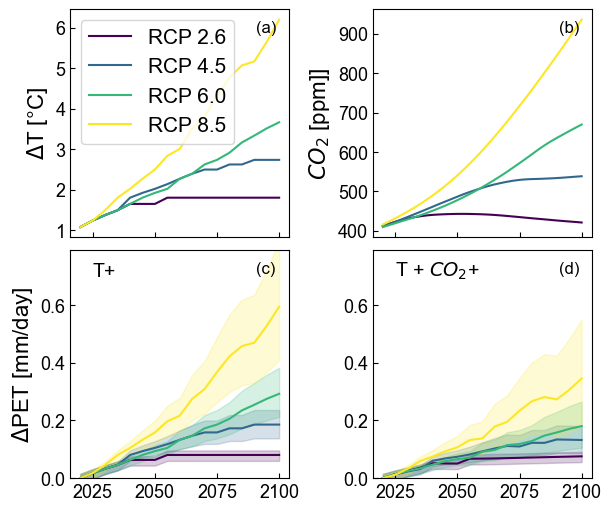

In [61]:
fig, axs = plt.subplots(2,2, figsize=(6, 5), constrained_layout=True, sharex=True)
axs = axs.flatten()
viridis = cm.get_cmap('viridis', len(rcp_temp.columns))
colors = [viridis(i) for i in range(0, len(rcp_temp.columns))]

for col, rcp, name in zip(colors, rcp_temp.columns, ["RCP 2.6", "RCP 4.5", "RCP 6.0", "RCP 8.5"]):
    axs[2].plot(dpet_rcp_et.loc[:, rcp]-dpet_rcp_et.loc[2020, rcp], c=col);
    axs[2].fill_between(dpet_rcp_et.index, dpet_rcp_et_5th[rcp]-dpet_rcp_et.loc[2020, rcp], 
                        dpet_rcp_et_95th[rcp]-dpet_rcp_et.loc[2020, rcp], color=col, alpha=0.2)
    axs[3].fill_between(dpet_rcp_et.index, dpet_rcp_etco2_5th[rcp]-dpet_rcp_etco2.loc[2020, rcp], 
                        dpet_rcp_etco2_95th[rcp]-dpet_rcp_etco2.loc[2020, rcp], color=col, alpha=0.2)
    axs[3].plot(dpet_rcp_etco2.loc[:, rcp]-dpet_rcp_etco2.loc[2020, rcp], c=col);
    axs[1].plot(rcp_co2[rcp], c=col)
    axs[0].plot(rcp_temp[rcp], c=col, label=name)

axs[0].set_ylabel(r"$\Delta$T [°C]")
axs[0].legend()

axs[1].set_ylabel("$CO_2$ [ppm]]")

axs[2].set_ylim(0, 0.79)
axs[2].set_ylabel("$\Delta$PET [mm/day]")

axs[3].set_ylim(0, 0.79)
#axs[3].set_xlim("2020", "2100")
axs[2].set_ylabel("$\Delta$PET [mm/day]")

axs[2].text(2025, 0.7, "T+", fontsize=14)
axs[3].text(2025, 0.7, "T + $CO_2$+", fontsize=14)

for i, letter in enumerate(["a", "b", "c", "d"]):
    axs[i].text(0.85, 0.9, "({})".format(letter), transform=axs[i].transAxes, fontsize=12)
    axs[i].tick_params(axis='both', which='major', labelsize=13)

#fig.savefig("figure5.png", dpi=600, bbox_inches="tight")

# Code example in paper

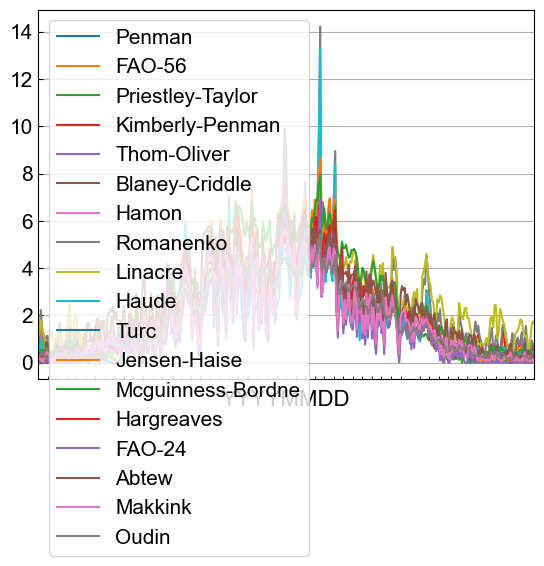

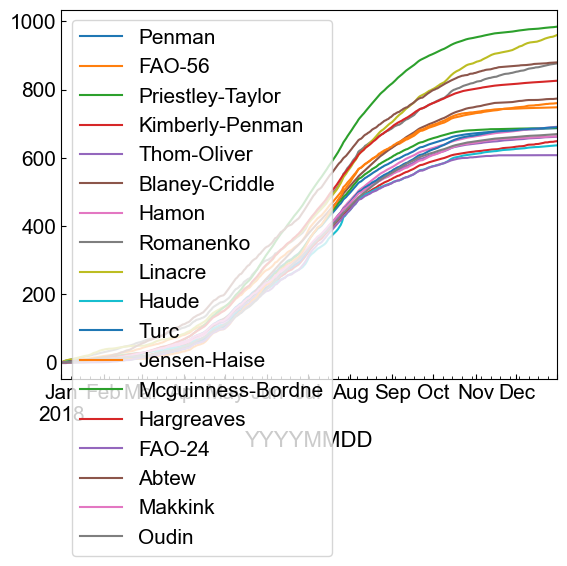

In [62]:
# 1. Import needed Python packages
import numpy as np
import pandas as pd

# 2. Reading meteorological data
meteo = pd.read_csv("data//example_0//0_example_meteo.csv", index_col=0, parse_dates=True)

# 3. Determining the necessary input data
tmean, tmax, tmin, rh, rs, wind, pet_knmi = (meteo[col] for col in meteo.columns)
lat = 0.91  # define latitude [radians]
elev = 4  # define elevation [meters above sea-level]

# 4. Estimate PET (all methods) and save the results in a Pandas.DataFrame
pet_df = pyet.calculate_all(tmean, wind, rs, elev, lat, tmax, tmin, rh)
                           
# (4. Estimate potential evaporation - Example with one method)
pyet_makkink = pyet.makkink(tmean, rs, elevation=elev)

# 5. Plot PET 
pet_df.plot()  # daily PET [mm/day]
pet_df.boxplot()  # boxplot PET[mm/day]
pet_df.cumsum().plot()  # cummulative PET [mm]
plt.scatter(pyet_makkink, pet_knmi)  # plot Makkink pyet vs KNMI

In [63]:
# 2. Reading meteorological data
meteo = pd.read_csv("data//example_0//0_example_meteo.csv", index_col=0, parse_dates=True)

In [64]:
# 3. Determining the necessary input data
tmean, tmax, tmin, rh, rs, wind, pet_knmi = (meteo[col] for col in meteo.columns)
lat = 0.91  # define latitude [radians]
elevation = 4  # define elevation [meters above sea-level]

Now that we have defined the input data, we can estimate potential evaporation with different estimation methods. 

In [65]:
# 4. Estimate potential evaporation (with all available methods) and save the results in a Pandas.DataFrame
pet_df  = pyet.calculate_all(tmean, wind, rs, elevation, lat, tmax, tmin, rh)

In [66]:
# 4. Estimate PE and save the results in a xarray.DataArray
pe_pm_fao56 = pyet.pm_fao56(tmean, wind, rs=rs, elevation=elevation, 
                            lat=lat, tmax=tmax, tmin=tmin, rh=rh)
pe_makkink = pyet.makkink(tmean, rs, elevation=elevation)
pe_pt = pyet.priestley_taylor(tmean, rs=rs, elevation=elevation, 
                              lat=lat, tmax=tmax, tmin=tmin, rh=rh)
pe_hamon = pyet.hamon(tmean, lat=lat) 
pe_blaney_criddle = pyet.blaney_criddle(tmean, lat)
pe_hargreaves = pyet.hargreaves(tmean, tmax, tmin, lat=lat)

# Acknowledgements

We acknowledge the financial support by the University of Graz and the funding of the Earth System Sciences research program of the the Austrian Academy of Sciences (ÖAW project ClimGrassHydro). We acknowledge the ZAMG dataset (https://data.hub.zamg.ac.at), KNMI dataset (https://www.knmi.nl/home), and the E-OBS dataset from the EU-FP6 project UERRA (http://www.uerra.eu) and the Copernicus Climate Change Service, and the data providers in the ECA\&D project (https://www.ecad.eu). 

# Literature

Abtew, W. (1996). Evapotranspiration measurements and modeling for three wetland systems in South Florida 1. JAWRA Journal of the American Water Resources Association, 32, 465-473. Publisher: Wiley Online Library.

Allen, R.G., Pereira, L.S., Raes, D., Smith, M., & others. (1998). Crop evapotranspiration-Guidelines for computing crop water requirements-FAO Irrigation and drainage paper 56. Rome: Fao, 300, D05109.

Ansorge, L., & Beran, A. (2019). Performance of simple temperature-based evaporation methods compared with a time series of pan evaporation measures from a standard 20 m2 tank. Journal of Water and Land Development, 41, 1-11. https://doi.org/10.2478/jwld-2019-0021.

Guo, D., Westra, S., & Maier, H. R. (2016). An R package for modelling actual, potential and reference evapotranspiration. Environmental Modelling & Software, 78, 216-224.

Hamon, W.R. (1963). Estimating potential evapotranspiration. Transactions of the American Society of Civil Engineers, 128, 324-338. Publisher: American Society of Civil Engineers.

Hargreaves, G.H., & Samani, Z.A. (1982). Estimating potential evapotranspiration. Journal of the irrigation and Drainage Division, 108, 225-230. Publisher: American Society of Civil Engineers. https://doi.org/10.1061/(ASCE)0733-9437(1983)109:3(341).

Haude, W. (1955). Determination of evapotranspiration by an approach as simple as possible. Mitt Dt Wetterdienst, 2.

Jensen, M.E., & Allen, R.G. (2016). Evaporation, Evapotranspiration, and Irrigation Water Requirements (2nd ed.). American Society of Civil Engineers. _eprint: https://ascelibrary.org/doi/pdf/10.1061/, https://doi.org/10.1061/9780784414057.

Jensen, M.E., Burman, R.D., Allen, R.G., & others. (1990). Evapotranspiration and irrigation water requirements. ASCE, New York.

Jensen, M.E., & Haise, H.R. (1963). Estimating evapotranspiration from solar radiation. Journal of the Irrigation and Drainage Division, 89, 15-41. Publisher: American Society of Civil Engineers. https://doi.org/10.1061/JRCEA4.0000287.

Linacre, E.T. (1977). A simple formula for estimating evaporation rates in various climates, using temperature data alone. Agricultural Meteorology, 18, 409-424. https://doi.org/https://doi.org/10.1016/0002-1571(77)90007-3.

Makkink, G.F. (1957). Testing the Penman formula by means of lysimeters. Journal of the Institution of Water Engineerrs, 11, 277-288.

McGuinness, J., & Bordne, E. (1972). A comparison of lysimeter derived potential evapotranspiration with computed values. Tech. Bull. Agric. Res. Serv., US Dep. of Agric., Washington, DC. https://doi.org/10.22004/ag.econ.171893.

McMahon, T.A., Peel, M.C., Lowe, L., Srikanthan, R., & McVicar, T.R. (2013). Estimating actual, potential, reference crop and pan evaporation using standard meteorological data: a pragmatic synthesis. Hydrology and Earth System Sciences, 17, 1331-1363. https://doi.org/10.5194/hess-17-1331-2013.

Monteith, J.L. (1965). Evaporation and environment. In Proceedings of the Symposia of the society for experimental biology. Cambridge University Press (CUP) Cambridge, Vol. 19, pp. 205-234.

Oudin, L., Michel, C., & Anctil, F. (2005). Which potential evapotranspiration input for a lumped rainfall-runoff model? Journal of Hydrology, 303, 275-289. https://doi.org/10.1016/j.jhydrol.2004.08.025.

Penman, H.L. (1948). Natural evaporation from open water, bare soil and grass. Proceedings of the Royal Society of London. Series A. Mathematical and Physical Sciences, 193, 120-145. Publisher: The Royal Society London.

Priestley, C.H.B., & Taylor, R.J. (1972). On the assessment of surface heat flux and evaporation using large-scale parameters. Monthly weather review, 100, 81-92.

Romanenko, V. (1961). Computation of the autumn soil moisture using a universal relationship for a large area. Proc. of Ukrainian Hydrometeorological Research Institute, 3, 12-25.

Schiff, H. (1975). Berechnung der potentiellen Verdunstung und deren Vergleich mit aktuellen Verdunstungswerten von Lysimetern. Archiv für Meteorologie, Geophysik und Bioklimatologie, Serie B, 23, 331-342. Publisher: Springer. https://doi.org/https://doi.org/10.1007/BF02242689.

Schrödter, H. (1985). Hinweise Für den Einsatz Anwendungsorientierter Bestimmungsverfahren. Berlin, Heidelberg: Springer Berlin Heidelberg. Publication Title: Verdunstung: Anwendungsorientierte Meßverfahren und Bestimmungsmethoden. https://doi.org/10.1007/978-3-642-70434-5_8.

Xu, C.Y., & Singh, V.P. (2001). Evaluation and generalization of temperature-based methods for calculating evaporation. Hydrological Processes, 15, 305-319. https://doi.org/https://doi.org/10.1002/hyp.119.

Thom, A., & Oliver, H. (1977). On Penman's equation for estimating regional evaporation. Quarterly Journal of the Royal Meteorological Society, 103, 345-357. Publisher: Wiley Online Library.

Turc, L. (1961). Estimation of irrigation water requirements, potential evapotranspiration: a simple climatic formula evolved up to date. Ann. Agron, 12, 13-49.

Walter, I.A., Allen, R.G., Elliott, R., Jensen, M., Itenfisu, D., Mecham, B., Howell, T., Snyder, R., Brown, P., Echings, S., et al. (2000). ASCE's standardized reference evapotranspiration equation. In Watershed management and operations management, pp. 1-11.

Wright, J.L. (1982). New evapotranspiration crop coefficients. Proceedings of the American Society of Civil Engineers, Journal of the Irrigation and Drainage Division, 108, 57-74.